<a href="https://colab.research.google.com/github/storwood/Fastai-course/blob/master/Lesson1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this lesson I will build our first image classifier from scratch using fastai.



In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate

I am going to use the Oxford-IIIT Pet Dataset by [O. M. Parkhi et al., 2012](https://www.robots.ox.ac.uk/~vgg/publications/2012/parkhi12a/parkhi12a.pdf) which features 12 cat breeds and 25 dogs breeds. My model will need to learn to differentiate between these 37 distinct categories. 

In [0]:
path = untar_data(URLs.PETS)

In [0]:
bs = 64

The first thing we do when we approach a problem is to take a look at the data. We always need to understand very well what the problem is and what the data looks like before we can figure out how to solve it. Taking a look at the data means understanding how the data directories are structured, what the labels are and what some sample images look like. The main difference between the handling of image classification datasets is the way labels are stored.



In [37]:
path.ls()

[PosixPath('/root/.fastai/data/oxford-iiit-pet/images'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/annotations')]

In [0]:
path_image = path/'images'
path_annotations = path/'annotations'

In [54]:
fnames = get_image_files(path_image)
fnames[:5]

[PosixPath('/root/.fastai/data/oxford-iiit-pet/images/yorkshire_terrier_177.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Bombay_208.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/pug_61.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/american_bulldog_2.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/american_pit_bull_terrier_53.jpg')]

The main difference between the handling of image classification datasets is the way labels are stored. In this particular dataset, labels are stored in the filenames themselves. I will  extract them to be able to classify the images into the correct categories.



In [0]:
np.random.seed(2)
pattern = r'/([^/]+)_\d+.jpg'


In [47]:
help(ImageDataBunch.from_name_re)

Help on method from_name_re in module fastai.vision.data:

from_name_re(path:Union[pathlib.Path, str], fnames:Collection[pathlib.Path], pat:str, valid_pct:float=0.2, **kwargs) method of builtins.type instance
    Create from list of `fnames` in `path` with re expression `pat`.



In [0]:
data = ImageDataBunch.from_name_re(path_image, fnames, pattern, ds_tfms=get_transforms(), size=224, bs=bs
                                  ).normalize(imagenet_stats)

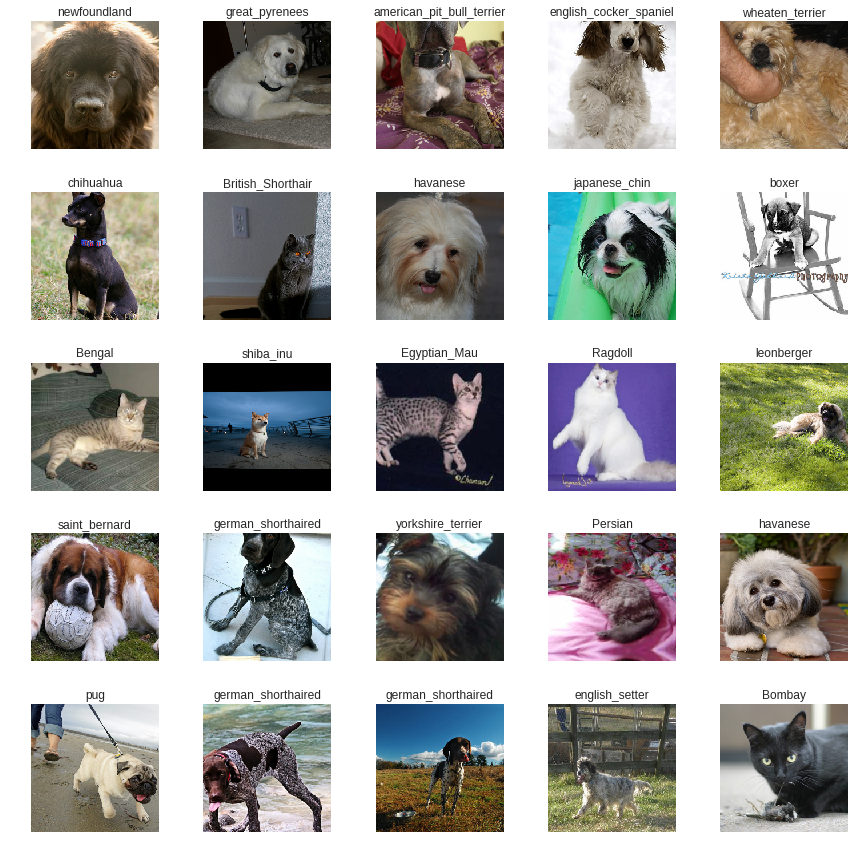

In [61]:
data.show_batch(rows = 5, figsize = (12,12))

In [62]:
print(data.classes)
len(data.classes),data.c

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


(37, 37)

# Training - resnet34
Now I will start training the model. I will use a convolutional neural network backbone and a fully connected head with a single hidden layer as a classifier. I will train for 4 epochs.



In [0]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

In [64]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [65]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate
1,1.390518,0.335823,0.108254
2,0.562851,0.242591,0.085250
3,0.354754,0.203070,0.063599
4,0.252519,0.199147,0.066982


In [0]:
learn.save("stage1-resnet34")

# Results

We will first see which were the categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not. In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly.

Furthermore, when we plot the confusion matrix, we can see that the distribution is heavily skewed: the model makes the same mistakes over and over again but it rarely confuses other categories. This suggests that it just finds it difficult to distinguish some specific categories between each other; this is normal behaviour.

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

In [70]:
losses,index = interp.top_losses()
len(data.valid_ds)==len(losses)==len(index)

True

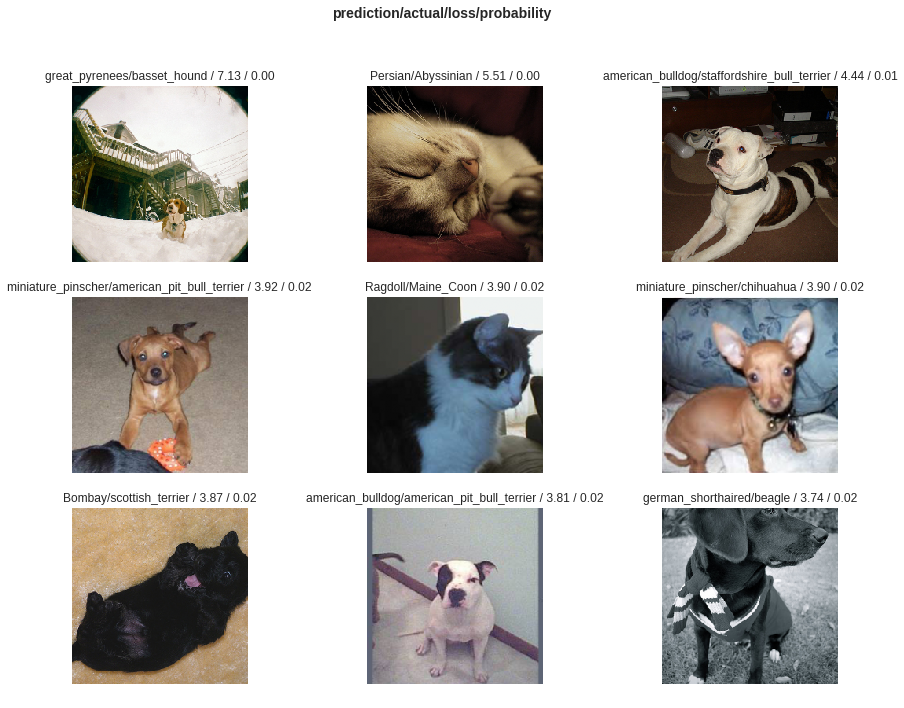

In [73]:
interp.plot_top_losses(9, figsize=(15,11))

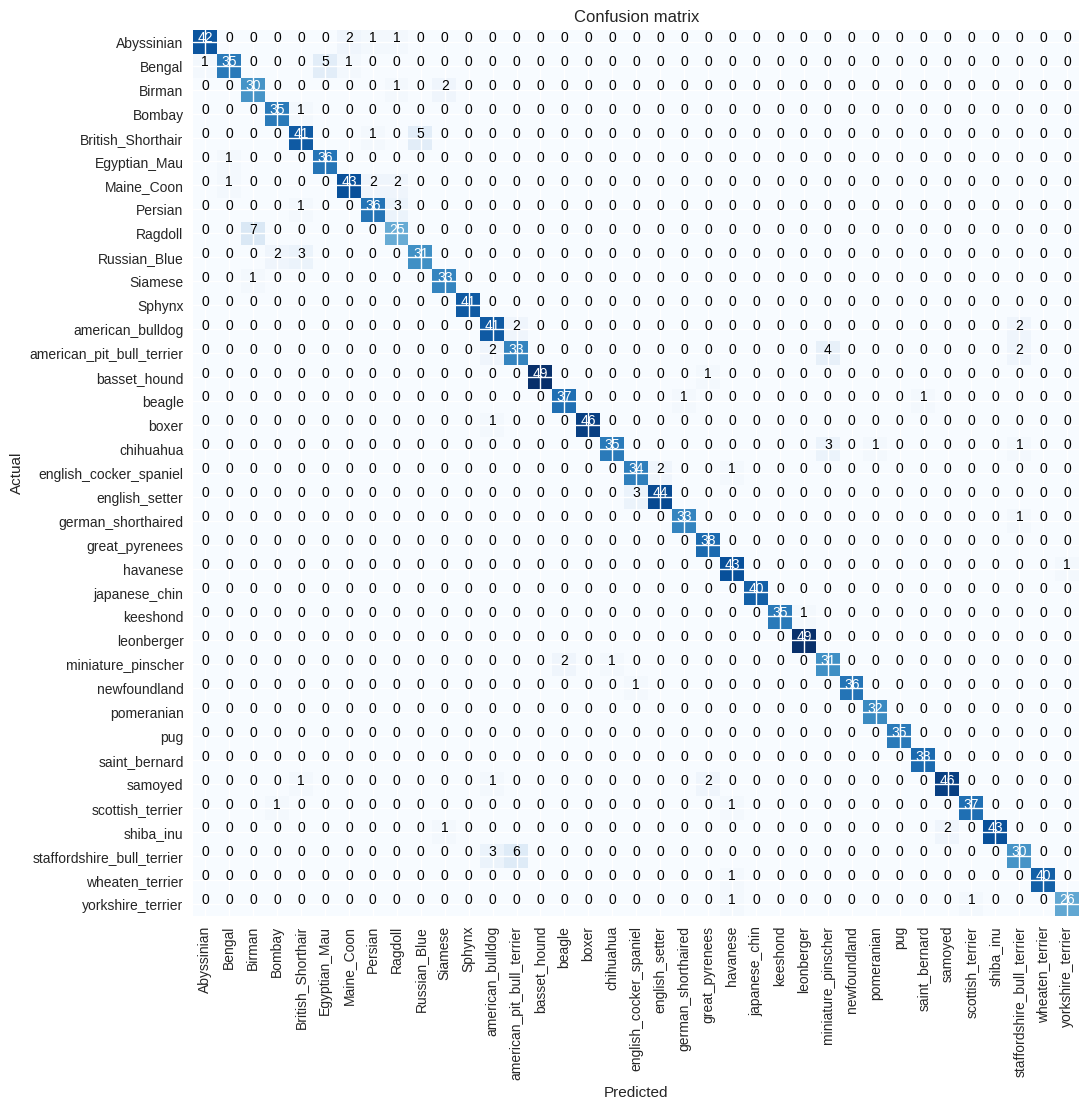

In [76]:
interp.plot_confusion_matrix(figsize=(15,11),dpi=100)

In [78]:
interp.most_confused(min_val=3)

[('Ragdoll', 'Birman', 7),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 6),
 ('Bengal', 'Egyptian_Mau', 5),
 ('British_Shorthair', 'Russian_Blue', 5),
 ('american_pit_bull_terrier', 'miniature_pinscher', 4)]

# Unfreezing, fine-tuning, and learning rates
Since the model is working as we expect it to, I will unfreeze our model and train in with another methods



In [0]:
learn.unfreeze()

In [80]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate
1,0.576594,0.315767,0.108254


In [0]:
learn.load('stage1-resnet34');

In [83]:
learn.lr_find()

epoch,train_loss,valid_loss,error_rate


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


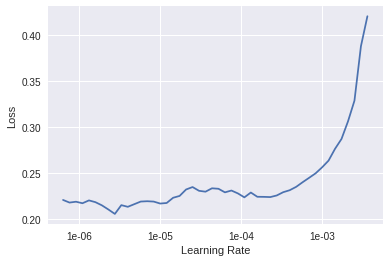

In [85]:
learn.recorder.plot()

In [86]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate
1,0.231267,0.186840,0.066306
2,0.211167,0.184362,0.065629


# Training - resnet50

Now I will train in the same way as before but with one caveat: instead of using resnet34 as our backbone I will use resnet50 (resnet34 is a 34 layer residual network while resnet50 has 50 layers.

Basically, resnet50 usually performs better because it is a deeper network with more parameters. Let's see if I can achieve a higher performance here. To help it along, let's use larger images too, since that way the network can see more detail. I reduce the batch size a bit since otherwise this larger network will require more GPU memory

In [0]:
data = ImageDataBunch.from_name_re(path_image, fnames, pattern, ds_tfms=get_transforms(), size=299, bs=bs//2
                                  ).normalize(imagenet_stats)

In [89]:
learn = create_cnn(data, models.resnet50, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:01<00:00, 85454572.37it/s]


In [90]:
learn.lr_find()

epoch,train_loss,valid_loss,error_rate


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


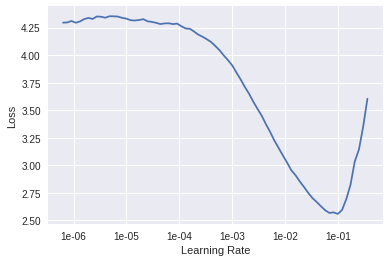

In [91]:
learn.recorder.plot()

In [92]:
learn.fit_one_cycle(8)

epoch,train_loss,valid_loss,error_rate
1,0.726671,0.306456,0.099459
2,0.417346,0.222009,0.074425
3,0.328074,0.235284,0.069689
4,0.284742,0.178076,0.058863
5,0.216133,0.166891,0.054127
6,0.158804,0.155173,0.057510
7,0.120420,0.139633,0.047361
8,0.100122,0.133520,0.048714


In [0]:
learn.save('stage2-resnet50')

In [95]:
learn.unfreeze()
learn.fit_one_cycle(3,max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate
1,0.108908,0.140605,0.049391
2,0.104352,0.140207,0.046685
3,0.082489,0.131940,0.043978


In [97]:
interp = ClassificationInterpretation.from_learner(learn)
interp.most_confused(min_val=3)

[('staffordshire_bull_terrier', 'american_pit_bull_terrier', 7),
 ('Egyptian_Mau', 'Bengal', 6),
 ('Russian_Blue', 'British_Shorthair', 6),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 5)]